Lecture week 7
==============



## preamble



In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import seaborn as sn
from scipy import optimize
import scipy as sc
import pymc3 as pm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import tensorflow as tf
import altair as alt
# from linearmodels.iv import IV2SLS
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
import arviz as az

import theano
import covid19pandas as cod
from country_codes import eurostat_dictionary
import eurostat
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

/opt/conda/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Bayesian models



### time series



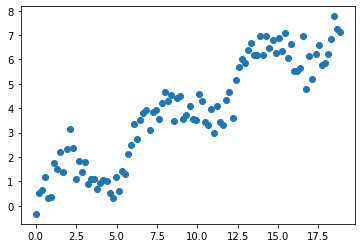

In [2]:
n = 100
x = np.linspace(0, 6*np.pi, n)
def time_series(x):
   return 0.4 * x + np.sin(x)
y = time_series(x) + np.random.normal(0, 0.5, n)
plt.scatter(x, y);

#### GP with periodic kernel



With a periodic kernel, the expression for this correlation uses something like $\sin(t-t')$. Hence, this correlation is high when $\sin$ equals 1. This gives the repetitive or cyclical part in the observations.

The exact expression for the correlation between observations at $t$ and $t'$ is given by:

\begin{equation}
\label{eq:5}
k(t,t') = e^{-\frac{ \sin^2(\pi |t-t' |\frac{1}{T})}{2\ell^{2}}}
\end{equation}

Then we add a cyclical and linear component to get `gp`.



In [3]:
X = x.reshape(n,1)

with pm.Model() as timeseries_periodic:
    # Cyclical component
    ls = pm.Gamma('ls', 1.0, 0.5)
    period = pm.Gamma('period',7,1)
    cov = pm.gp.cov.Periodic(input_dim=1, period = period, ls=ls)
    gp1 = pm.gp.Marginal(cov_func=cov)
    # Linear trend.
    c = pm.Normal(name='c', mu=0, sigma=1)
    gp2 = pm.gp.Marginal(cov_func=pm.gp.cov.Linear(input_dim=1, c=c))
    # adding the two components
    gp = gp1 + gp2
    sigma = pm.HalfCauchy('sigma', 0.5)
    y_est = gp.marginal_likelihood('y_est', X=X, y=y, noise=sigma)

#### Covid data



Another way to model time series is to explicitly model the underlying process.

We use the `covid19pandas` library to load the latest covid data directly into a dataframe.



In [4]:
global_df = cod.get_data_jhu()
global_df.head()

These data were obtained from Johns Hopkins University (https://github.com/CSSEGISandData/COVID-19).


,date,UID,iso2,iso3,code3,Province/State,Country/Region,Lat,Long,Combined_Key,Population,cases,deaths,recovered
0,2020-01-22,4.0,AF,AFG,4.0,NaN,Afghanistan,33.93911,67.709953,Afghanistan,38928341.0,0,0,0
1,2020-01-22,8.0,AL,ALB,8.0,NaN,Albania,41.15330,20.168300,Albania,2877800.0,0,0,0
2,2020-01-22,12.0,DZ,DZA,12.0,NaN,Algeria,28.03390,1.659600,Algeria,43851043.0,0,0,0
3,2020-01-22,20.0,AD,AND,20.0,NaN,Andorra,42.50630,1.521800,Andorra,77265.0,0,0,0
4,2020-01-22,24.0,AO,AGO,24.0,NaN,Angola,-11.20270,17.873900,Angola,32866268.0,0,0,0


To get an overview of the countries and regions available in this dataset, use the following code:



In [5]:
global_df['Country/Region'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana',
       'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Gua

We will consider the Dutch corona data. But feel free to experiment by looking at different countries.



In [6]:
df_nl = cod.select_regions(
    data = global_df,
    region_col="Combined_Key",
    regions = "Netherlands")
df_nl.head()

,date,UID,iso2,iso3,code3,Province/State,Country/Region,Lat,Long,Combined_Key,Population,cases,deaths,recovered
199,2020-01-22,528.0,NL,NLD,528.0,NaN,Netherlands,52.1326,5.2913,Netherlands,17134873.0,0,0,0
484,2020-01-23,528.0,NL,NLD,528.0,NaN,Netherlands,52.1326,5.2913,Netherlands,17134873.0,0,0,0
769,2020-01-24,528.0,NL,NLD,528.0,NaN,Netherlands,52.1326,5.2913,Netherlands,17134873.0,0,0,0
1054,2020-01-25,528.0,NL,NLD,528.0,NaN,Netherlands,52.1326,5.2913,Netherlands,17134873.0,0,0,0
1339,2020-01-26,528.0,NL,NLD,528.0,NaN,Netherlands,52.1326,5.2913,Netherlands,17134873.0,0,0,0


The column `cases` contains the accumulated number of cases recorded for the country. To create the column `new cases` we take the first difference using `.diff()`.



In [7]:
df_nl['new cases'] = df_nl.cases.diff()

#### Question: plot the `new cases`.



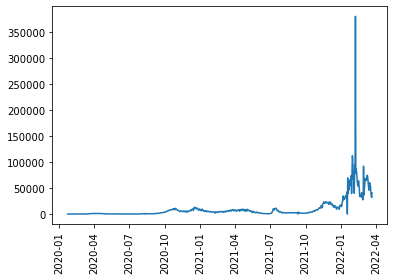

In [11]:
plt.plot(df_nl['date'],df_nl['new cases'])
plt.xticks(rotation=90);

#### date selection



The idea here is to model exponential growth, which &#x2013;at the start&#x2013; is a feature of an epidemic. For this we need the time period starting from the situation where part of the population is already infected. Hence, we take &#x2013;rather arbitrarily&#x2013; as starting point 1-5-2020. We take as end point 1-11-2020 when policy measures were taken to reduce the spread of the virus.



#### Question: use pandas `.date.between()` method to select the dates 1/5/2020-1/11/2020 from `df_nl` and call this dataframe `df`.



[hint: check the pandas documentation for this method]

Then over this date range, plot `new cases` and `cases`.



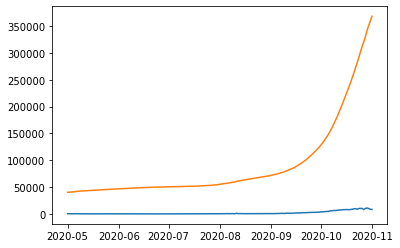

In [22]:
df = df_nl[df_nl.date.between('2020-05-01','2020-11-01')]
plt.plot(df['date'],df['new cases'])
plt.plot(df['date'],df['cases']);

#### Question: create a Bayesian model `exponential_model` by completing the following code block.



As case numbers become quite big, from a numerical point of view it is easier to work with log case numbers. Then we model `log_cases` as log-normal.

In the code block below, choose the priors for the parameters `a,b,eps`.



In [33]:
t = np.arange(0,len(df))
Log_cases = np.log(df.cases)

with pm.Model() as exponential_model:
    a = pm.HalfNormal('a',10)
    b = pm.Normal('b',mu=0.1,sd=0.1)

    y = a * (1+b) ** t

    eps = pm.HalfNormal('eps',1)

    log_cases = pm.Lognormal('log_cases', mu = pm.math.log(y),\
                             sigma = eps, observed = Log_cases)
    prior_predictive = pm.sample_prior_predictive(samples=50)

Note that this model looks a bit different from the `pymc3` models above. In particular, the last line does not specify observed values. In contrast, it uses the `sample_prior_predictive()` method to generate predictions from the prior.



#### plot the predictive prior



Use the following code to plot your prior predictions and check whether your outcomes look reasonable/plausible.



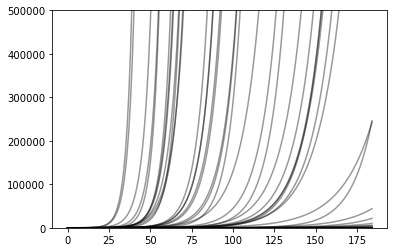

In [36]:
for a, b in zip(prior_predictive['a'],prior_predictive['b']):
    y = a*(1+b)**t
    plt.plot(t,y,c='k',alpha=0.4)

plt.ylim(0,500000);

#### Question: generate a trace from `exponential_model`; set `tune = 2000`.



-   create trace plots for `a,b,eps`
-   show the table summarizing the trace; what do you find for `r_hat`?



In [37]:
with exponential_model:
    trace = pm.sample(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 73 seconds.
The acceptance probability does not match the target. It is 0.8837276271813564, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

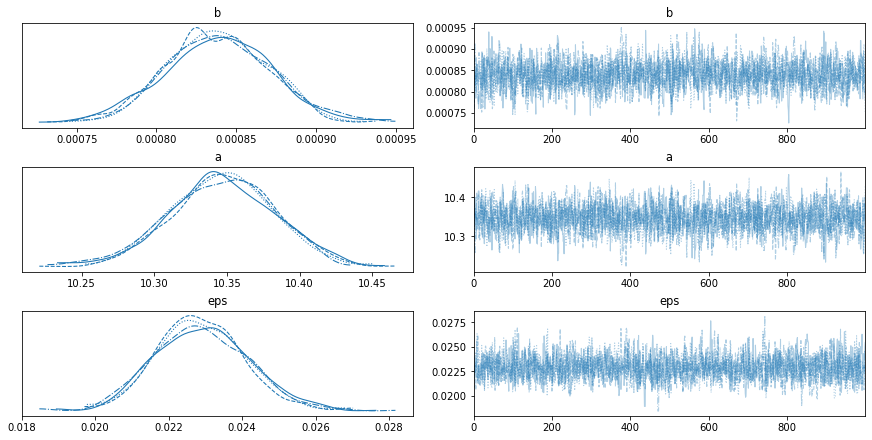

In [38]:
pm.traceplot(trace)

In [39]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b,0.001,0.000,0.001,0.001,0.000,0.000,1763.0,1783.0,1.0
a,10.347,0.036,10.280,10.413,0.001,0.001,1825.0,1904.0,1.0
eps,0.023,0.001,0.021,0.025,0.000,0.000,2227.0,1925.0,1.0


### neural network



-   Bayesian neural networks are do-able now
-   but require a bit of programming
-   this will become easier in a year or two
-   conceptually it is important to understand what information a neural network provides about uncertainty
-   this is part of the &ldquo;black box&rdquo; feature of a neural network
-   suppose we want to classify pictures with cats and dogs:
    -   compare two pictures where one is classified as dog with 0.51 prob.; the other with 0.99 probability
    -   when you run the neural network 1000 times, the latter features probabilities 0.01 and 0.99 each 500 times&#x2026;



### confidence interval



To make clear what a confidence interval is in &ldquo;standard&rdquo; (frequentist) econometrics, we will simulate this interval for an example: we draw a sample $x_1,...,x_n$ from a normal distribution with (unknown) mean $\mu$ and (known) standard deviation $\sigma=1$. We calculate the sample mean $m = \sum x_i/n$ and the 95% confidence interval $[m - 2 \sigma_m, m + 2 \sigma_m]$ where $\sigma_m = \sigma/\sqrt(n)$ denotes the standard deviation of the sample mean $m$.



In [11]:
def interval_95(X,σ):
    """X should be of the form: number of repetitions (in rows) times sample (in columns)"""
    mean = X.mean(axis=1) # for each row (repetition) take the mean across the sample
    σ_m = σ/np.sqrt(X.shape[1])
    return np.array([mean - 1.96 * σ_m, mean + 1.96 * σ_m])

μ = 100
σ = 10
repetions = 100_000
n_sample = 9
X = np.random.normal(μ,σ,size = (repetions,n_sample))

#### Question: calculate in which percentage of cases $\mu$ lies in this 95% interval



Note that $\mu$ does not vary when we are doing these simulations; it stays fixed at $\mu=100$.



In [12]:
intervals = interval_95(X,10)
test = (intervals[0] < μ) & (μ < intervals[1])
np.sum(test)/len(test)

0.94977

## Final assignment



-   link to the final assignment repos. is on Canvas
-   create a team (at max. 2 students) and start working!
-   hand in your assignment on github before the deadline
-   fill in the google form with the link to your repos.
-   convince us that you learned something about datascience
-   e.g. show that you can analyze data both with a neural network and a Bayesian model
-   and illustrate your main results with an (interactive) figure
-   to motivate the technique that you are using, generate your own data and show that your method can recover the relevant parameters
-   with a neural network show how you choose your hyper-parameters (e.g. number of epochs with the trade off between  over- and under-fitting)
-   with a Bayesian model check the trace plot, `r_hat` etc. and discuss how these should be interpreted

